# mm3 Segmentation Debug Notebook

- Use this notebook to test your segmentation algorithm on your images, or write your own. 
- Then put your custom algorithm into mm3_helpers.py function segment_image

#### Load Modules

In [74]:
#!/usr/bin/python
from __future__ import print_function

# import modules
import sys
import os
import time
import inspect
import yaml
import json # for importing tiff metdata
try:
    import cPickle as pickle # pickle
except:
    import pickle
import numpy as np
import scipy.signal as spsig # used in channel finding
import scipy.stats as spstats
from scipy.optimize import curve_fit
import struct # for interpretting strings as binary data
import re # regular expressions
import traceback
import copy
import warnings
import h5py

# Image analysis modules
from scipy import ndimage as ndi
from skimage import segmentation # used in make_masks and segmentation
from skimage.feature import match_template # used to align images
from skimage.filters import threshold_otsu
from skimage import morphology # many functions is segmentation used from this
from skimage.measure import regionprops # used for creating lineages

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [75]:
# you need to import mm3_helpers
sys.path.insert(0, '../')
import mm3_helpers as mm3

### Load parameters file

- Put in the path to your parameters file!

In [76]:
param_file_path = '/path/to/your/param/file.yaml'
params = mm3.init_mm3_helpers(param_file_path)

# load specs file
with open(params['ana_dir'] + '/specs.pkl', 'r') as specs_file:
    specs = pickle.load(specs_file)

print(specs)

# Segment image test

- Use this to test segmentation on one image

### Load some cells and images

- choose an FOV and Peak ID for channel that has cells in it.
- or let the code just choose the first peak with cells in it
- Same goes for a timepoint.

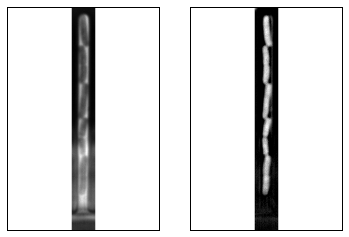

In [82]:
# manually pick peak and timepoint to test
# fov_id = 1
# peak_id = 0

# automatically choose first analyzed peak
for fov_id, peaks in specs.items():
    for peak_id, spec in peaks.items():
        if spec == 1:
            # just break out with the current fov_id and peak_id
            break
            
timepoint = 0
    
print('FOV %d peak %d time point %d' % (fov_id, peak_id, timepoint))

# load phase contrast image
img_stack = mm3.load_stack(fov_id, peak_id, color='c2')
pc_img = img_stack[timepoint]

# load subtracted image
sub_stack = mm3.load_stack(fov_id, peak_id, color='sub_c2')
# take first time point
sub_img = sub_stack[timepoint]

# plot
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(pc_img, cmap=plt.cm.gray)
ax[1].imshow(sub_img, cmap=plt.cm.gray)

for axis in axes:
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
plt.show()

### Choose parameters and run segmentation
- This segmentation script is the same one in mm3.segment_image function

In [ ]:
# choose parameters 
first_opening_size = 3
distance_threshold = 3
second_opening_size = 2
min_object_size = 20

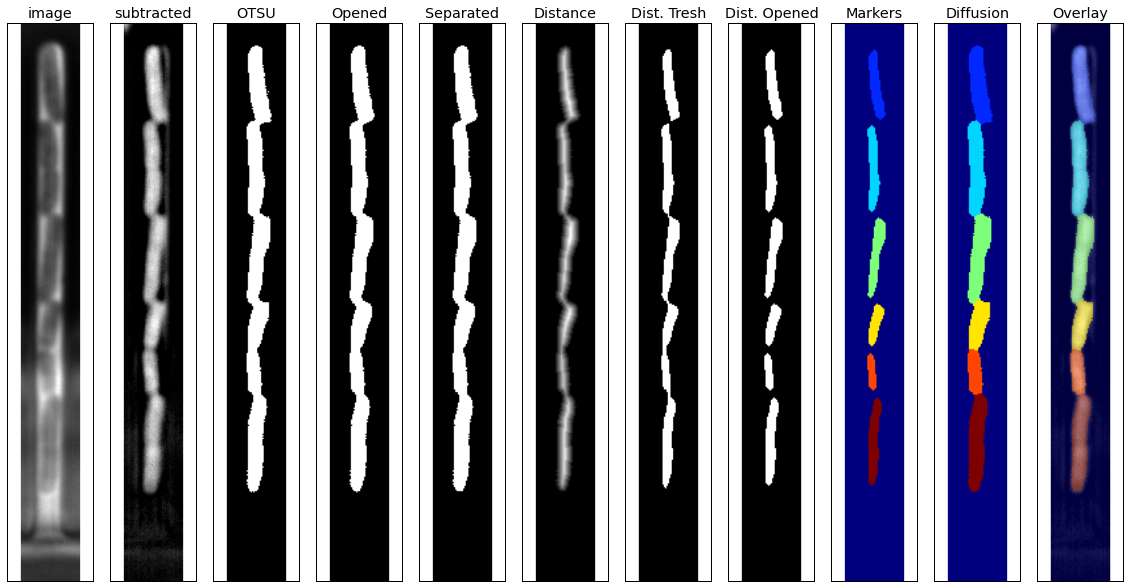

In [83]:
# threshold image
thresh = threshold_otsu(sub_img) # finds optimal OTSU thershhold value
threshholded = sub_img > thresh # will create binary image

# if there are no cells, good to clear the border
# because otherwise the OTSU is just for random bullshit, most
# likely on the side of the image
threshholded = segmentation.clear_border(threshholded)
thresholded_plot = threshholded.copy()

# Opening = erosion then dialation.
# opening smooths images, breaks isthmuses, and eliminates protrusions.
# "opens" dark gaps between bright features.
morph = morphology.binary_opening(threshholded, morphology.disk(first_opening_size))
opening_plot = morph.copy()

# if this image is empty at this point (likely if there were no cells), just return
# the morphed image which is a zero array
if np.amax(morph) == 0:
    print('No cells in after thresholding and opening')
    pass

# zero out rows that have very few pixels
# widens or creates gaps between cells
# sum of rows (how many pixels are occupied in each row)
line_profile = np.sum(morph, axis=1)
# find highest value, aka width of fattest cell
max_width = max(line_profile)
# find indexes of rows where sum is less than 1/5th of this value.
zero_these_indicies = np.all([line_profile < (max_width/5), line_profile > 0], axis=0)
zero_these_indicies = np.where(zero_these_indicies)
# zero out those rows
morph[zero_these_indicies] = 0
separated_plot = morph.copy()

### Calculate distnace matrix, use as markers for random walker (diffusion watershed)
# Generate the markers based on distance to the background
distance = ndi.distance_transform_edt(morph)
distance_plot = distance.copy()

# threshold distance image
distance_thresh = np.zeros_like(distance)
distance_thresh[distance < distance_threshold] = 0
distance_thresh[distance >= distance_threshold] = 1
distance_thresh_plot = distance_thresh.copy()

# do an extra opening on the distance
distance_opened = morphology.binary_opening(distance_thresh, 
                                            morphology.disk(second_opening_size))
distance_opened_plot = distance_opened.copy()

# remove artifacts connected to image border
cleared = segmentation.clear_border(distance_opened)
# remove small objects. Remove small objects wants a
# labeled image and will fail if there is only one label. Return zero image in that case
# could have used try/except but remove_small_objects loves to issue warnings.
cleared, label_num = morphology.label(cleared, connectivity=1, return_num=True)
if label_num > 1:
    cleared = morphology.remove_small_objects(cleared, min_size=min_object_size)
else:
    pass

# relabel now that small objects and labels on edges have been cleared
markers = morphology.label(cleared)
markers_plot = markers.copy()

# label using the random walker (diffusion watershed) algorithm
# set anything outside of OTSU threshold to -1 so it will not be labeled
markers[threshholded == 0] = -1
# here is the main algorithm
labeled_image = segmentation.random_walker(-1*sub_img, markers)
# put negative values back to zero for proper image
labeled_image[labeled_image == -1] = 0

# or watershed
# labeled_image = morphology.watershed(-1*sub_img, markers, mask=threshholded)

### Plot it up. 
fig, axes = plt.subplots(ncols=11, figsize=(20, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title('image')
ax[0].imshow(pc_img, cmap=plt.cm.gray)

ax[1].set_title('subtracted')
ax[1].imshow(sub_img, cmap=plt.cm.gray)

ax[2].set_title('OTSU')
ax[2].imshow(thresholded_plot, cmap=plt.cm.gray)

ax[3].set_title('Opened')
ax[3].imshow(opening_plot, cmap=plt.cm.gray)

ax[4].set_title('Separated')
ax[4].imshow(separated_plot, cmap=plt.cm.gray)

ax[5].set_title('Distance')
ax[5].imshow(distance_plot, cmap=plt.cm.gray)

ax[6].set_title('Dist. Tresh')
ax[6].imshow(distance_thresh_plot, cmap=plt.cm.gray)

ax[7].set_title('Dist. Opened')
ax[7].imshow(distance_opened_plot, cmap=plt.cm.gray)

ax[8].set_title('Markers')
ax[8].imshow(markers_plot)

ax[9].set_title('Diffusion')
ax[9].imshow(labeled_image)

ax[10].set_title('Overlay')
ax[10].imshow(sub_img, cmap=plt.cm.gray)
ax[10].imshow(labeled_image, alpha=0.5)

for axis in axes:
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

# Segmentation parameter sweep
- Here, you can plot the above graph for combinations of parameters for many time points
- First, we make a directory for these images
- Then, we define a segmentation function which is the same as the one above and in mm3. 
- Finally, we choose a range of parameters and the desired number of samples

In [ ]:
# Make directory for this 
seg_test_dir = os.path.join(params['experiment_directory'], params['analysis_directory'],
                       'segment_testing')
if not os.path.exists(seg_test_dir):
    os.makedirs(seg_test_dir)

In [ ]:
def segment(fov_id, peak_id, timepoint, 
            first_opening_size, distance_threshold, second_opening_size):

    ### Load images ##############################################
    # load phase contrast image
    img_stack = mm3.load_stack(fov_id, peak_id, color='c1')
    pc_img = img_stack[timepoint]

    # load subtracted image
    sub_stack = mm3.load_stack(fov_id, peak_id, color='sub_c1')
    # take first time point
    sub_img = sub_stack[timepoint]

    ### Segment image ############################################
    # threshold image
    thresh = threshold_otsu(sub_img) # finds optimal OTSU thershhold value
    threshholded = sub_img > thresh # will create binary image

    # if there are no cells, good to clear the border
    # because otherwise the OTSU is just for random bullshit, most
    # likely on the side of the image
    threshholded = segmentation.clear_border(threshholded)
    thresholded_plot = threshholded.copy()

    # Opening = erosion then dialation.
    # opening smooths images, breaks isthmuses, and eliminates protrusions.
    # "opens" dark gaps between bright features.
    morph = morphology.binary_opening(threshholded, morphology.disk(first_opening_size))
    opening_plot = morph.copy()

    # if this image is empty at this point (likely if there were no cells), just return
    # the morphed image which is a zero array
    if np.amax(morph) == 0:
        print('No cells in after thresholding and opening')
        pass

    # zero out rows that have very few pixels
    # widens or creates gaps between cells
    # sum of rows (how many pixels are occupied in each row)
    line_profile = np.sum(morph, axis=1)
    # find highest value, aka width of fattest cell
    max_width = max(line_profile)
    # find indexes of rows where sum is less than 1/3th of this value.
    zero_these_indicies = np.all([line_profile < (max_width/3), line_profile > 0], axis=0)
    zero_these_indicies = np.where(zero_these_indicies)
    # zero out those rows
    morph[zero_these_indicies] = 0
    separated_plot = morph.copy()

    ### Calculate distnace matrix, use as markers for random walker (diffusion watershed)
    # Generate the markers based on distance to the background
    distance = ndi.distance_transform_edt(morph)
    distance_plot = distance.copy()

    # threshold distance image
    distance_thresh = np.zeros_like(distance)
    distance_thresh[distance < distance_threshold] = 0
    distance_thresh[distance >= distance_threshold] = 1
    distance_thresh_plot = distance_thresh.copy()

    # do an extra opening on the distance
    distance_opened = morphology.binary_opening(distance_thresh, 
                                                morphology.disk(second_opening_size))
    distance_opened_plot = distance_opened.copy()

    # remove artifacts connected to image border
    cleared = segmentation.clear_border(distance_opened)
    # remove small objects. Remove small objects wants a
    # labeled image and will fail if there is only one label. Return zero image in that case
    # could have used try/except but remove_small_objects loves to issue warnings.
    cleared, label_num = morphology.label(cleared, connectivity=1, return_num=True)
    if label_num > 1:
        cleared = morphology.remove_small_objects(cleared, min_size=min_object_size)
    else:
        pass

    # relabel now that small objects and labels on edges have been cleared
    markers = morphology.label(cleared)
    markers_plot = markers.copy()

    # label using the random walker (diffusion watershed) algorithm
    # set anything outside of OTSU threshold to -1 so it will not be labeled
    markers[threshholded == 0] = -1
    # here is the main algorithm
    labeled_image = segmentation.random_walker(-1*sub_img, markers)
    # put negative values back to zero for proper image
    labeled_image[labeled_image == -1] = 0

    # or watershed
    # labeled_image = morphology.watershed(-1*sub_img, markers, mask=threshholded)

    ### Plot it up. 
    fig, axes = plt.subplots(ncols=11, figsize=(20, 10), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].set_title('image')
    ax[0].imshow(pc_img, cmap=plt.cm.gray)

    ax[1].set_title('subtracted')
    ax[1].imshow(sub_img, cmap=plt.cm.gray)

    ax[2].set_title('OTSU')
    ax[2].imshow(thresholded_plot, cmap=plt.cm.gray)

    ax[3].set_title('Opened')
    ax[3].imshow(opening_plot, cmap=plt.cm.gray)

    ax[4].set_title('Separated')
    ax[4].imshow(separated_plot, cmap=plt.cm.gray)

    ax[5].set_title('Distance')
    ax[5].imshow(distance_plot, cmap=plt.cm.gray)

    ax[6].set_title('Dist. Tresh')
    ax[6].imshow(distance_thresh_plot, cmap=plt.cm.gray)

    ax[7].set_title('Dist. Opened')
    ax[7].imshow(distance_opened_plot, cmap=plt.cm.gray)

    ax[8].set_title('Markers')
    ax[8].imshow(markers_plot)

    ax[9].set_title('Diffusion')
    ax[9].imshow(labeled_image)

    ax[10].set_title('Overlay')
    ax[10].imshow(sub_img, cmap=plt.cm.gray)
    ax[10].imshow(labeled_image, alpha=0.5)

    for axis in ax:
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    ax[0].get_yaxis().set_visible(True)
    ax[0].set_ylabel('FOV {:03d}, Peak {:04d}, t {:04d}'.format(fov_id, peak_id, timepoint), size=16)

    fig.suptitle('Opening 1 = {}, Distance Threshold = {}, Opening 2 = {}'.format(osize1, dthresh, osize2), size=20)
        
    return fig, ax

In [ ]:
# choose parameter ranges
first_opening_sizes = [1, 2, 3]
distance_thresholds = [1, 2, 3]
second_opening_sizes = [1, 2, 3]
min_object_size = 20

# determine number of images to be analyzed 
no_samples = 20
# list contains tuples of (fov_id, peak_id, timepoint)
sample_ids = [] 
timepoints = None # place holder for number of time points
for fov_id in specs.keys():
    for peak_id, spec in specs[fov_id].items():
        if spec == 1:
            
            # If we don't know the number of time points, figure that out now
            if timepoints is None:
                # should pull out the number of timepoints. 
                timepoints = len(mm3.load_stack(fov_id, peak_id, color='c1'))
            
            # now put the fov, peak, and a random timepoint in a tuple
            sample_ids.append((fov_id, peak_id, np.random.choice(timepoints, 1)[0]))
            
# choose a random subset of these and sort them
sample_indicies = np.random.choice(len(sample_ids), no_samples)
sample_ids = sorted([sample_ids[i] for i in sample_indicies]) 

# create list of all combinations 
p_combos = []
for osize1 in first_opening_sizes:
    for dthresh in distance_thresholds:
        for osize2 in second_opening_sizes:
            p_combos.append((osize1, dthresh, osize2))

# cycle through all sample and parameter combinations
for sample in sample_ids:
    fov_id, peak_id, timepoint = sample
    for p_combo in p_combos:
        osize1, dthresh, osize2 = p_combo
        try:
            fig, ax = segment(fov_id, peak_id, timepoint, 
                              osize1, dthresh, osize2)
            
        except:
            print('{}{}{}_xy{:03d}_p{:04d}_t{:04d} has no cells'.format(osize1, dthresh, osize2, 
                                                                 fov_id, peak_id, timepoint))
            continue
        seg_filename = '{}{}{}_xy{:03d}_p{:04d}_t{:04d}.png'.format(osize1, dthresh, osize2, 
                                                                 fov_id, peak_id, timepoint)
        seg_filepath = os.path.join(seg_test_dir, seg_filename)
        fig.savefig(seg_filepath, dpi=75)
        plt.close()

# Plot lineages
- This create the graph of the lineages super-imposed on the segmented images. 
- This is to be done after segmentation for an entire channel

In [ ]:
# The linage plotting function is in mm3.plots
import mm3_plots as mm3_plots

In [ ]:
# plotting lineage trees for complete cells
with open(os.path.join(params['cell_dir'], 'complete_cells.pkl'), 'r') as cell_file:
    Cells = pickle.load(cell_file)

lin_dir = os.path.join(params['experiment_directory'], params['analysis_directory'],
                       'lineages_complete_cells')
if not os.path.exists(lin_dir):
    os.makedirs(lin_dir)

for fov_id, peaks in specs.items():
    for peak_id, spec in peaks.items():
        if spec == 1:
            fig, ax = mm3_plots.plot_lineage_images(Cells, fov_id, peak_id)
            lin_filename = params['experiment_name'] + '_xy%03d_p%04d_lin.png' % (fov_id, peak_id)
            lin_filepath = os.path.join(lin_dir, lin_filename)
            fig.savefig(lin_filepath, dpi=75)
            plt.close()

# # plotting lineage trees for all cells
# with open(os.path.join(params['cell_dir'], 'all_cells.pkl'), 'r') as cell_file:
#     Cells = pickle.load(cell_file)
            
# lin_dir = os.path.join(params['experiment_directory'], params['analysis_directory'],
#                        'lineages_all_cells')
# if not os.path.exists(lin_dir):
#     os.makedirs(lin_dir)

# for fov_id, peaks in specs.items():
#     for peak_id, spec in peaks.items():
#         if spec == 1:
#             fig, ax = mm3_plots.plot_lineage_images(Cells, fov_id, peak_id)
#             lin_filename = params['experiment_name'] + '_xy%03d_p%04d_lin.png' % (fov_id, peak_id)
#             lin_filepath = os.path.join(lin_dir, lin_filename)
#             fig.savefig(lin_filepath, dpi=75)
            
#             plt.close()